<img align="center" src="https://raw.githubusercontent.com/FUlyankin/Parsers/master/images%20/cats.jpg" height="1200" width="1200"> 

# Мини-домашка 6: регрессия

На семинаре мы пытались спрогнозировать сколько лайков поставит студент первого курса в вышкинский паблик с мемасами. Наша итоговая модель получилась довольно хлипкой. Хотелось бы улучшить её. В этом домашнем задании именно этим вы и займётесь. По ходу кода ниже будет довольно много пустых строк. Нужно заполнить их своим кодом. 

In [1]:
import pandas as pd               # уже знакомый вам пакет для работы с таблицами
import numpy as np                # смутно знакомый вам пакет для работы с матрицами
import matplotlib.pyplot as plt   # уже смутно знакомый вам пакет для картинок :3
import seaborn as sns             # ещё один пакет для картинок 
plt.style.use('ggplot')     # правильный (очень красивый) стиль у графиков

%matplotlib inline

In [2]:
# Функция для визуализации прогнозов 

def plot_yreal_ypred(y_test, y_train, X_test, X_train, model, margin=0.3):
    """
        Рисует картинку для прогнозов
            modelt - модель 
            y_train, X_train - обучающая выборка
            y_test, X_test - тестовая выборка
            margin - граница рисунка 
    """
    
    plt.figure(figsize=(16,7))
    plt.subplot(121)
    plt.scatter(y_train, model.predict(X_train), color="red", alpha=1)
    plt.xlim(min(y_train) - margin, max(y_train) + margin)
    plt.ylim(min(y_train) - margin, max(y_train) + margin)
    plt.title('Train set', fontsize=20)
    plt.xlabel('y', fontsize=14)
    plt.ylabel('Estimated y', fontsize=14)

    plt.subplot(122)
    plt.scatter(y_test, model.predict(X_test), color="red", alpha=1)
    plt.xlim(min(y_test) - margin, max(y_test) + margin)
    plt.ylim(min(y_test) - margin, max(y_test) + margin)
    plt.title('Test set', fontsize=20)
    plt.xlabel('y', fontsize=14)
    plt.ylabel('Estimated y', fontsize=14)
    pass

## 1. Гипотеза для раскрутки 

Семинар мы закончили, построив визуализацию для прогнозов. Она получилась вот такой: 

![](https://raw.githubusercontent.com/FUlyankin/HSE_Data_Culture/master/Intro_to_DS_2019/sem_6_regression/our_sem_regr.png)

По оси $x$ мы отклаыдваем настоящее число лайков. По оси $y$ прогнозируемое. Если наша модель строит хорошие прогнозы, тогда все наши точки должны выстроиться по диагонали. Это будет означать, что $y = \hat y$. То есть, что реальное число лайов совпало с прогнозируемым.

Давайте обратим с вами внимание на следущий факт. Довольно часто у нас не получается спрогнозировать нулевое число лайков. Скорее всего, это происходит из-за того, что они обладают другой природой. Человек банально мог не подписаться на паблик и из-за этого не лайкает его. 

__Давайте попробуем сконцентрироваться только на тех людях, которые поставили в палбике свой лайк. Возможно, для такой ситуации нам удастся построить адекватную модель, которая будет значимо бить константный прогноз.__ План будет таким: 

1. Предобрабатываем данные 
2. Строим константный прогноз 
3. Строим линейную регрессию c MSE в качестве функции ошибки 
4. Строим линейную регрессию с модернизацией MAE в качестве функции ошибки
5. Сравниваем качество прогнозов и делаем выводы

Подгружаем данные.

In [3]:
df = pd.read_csv('../data/vk_main.csv', sep='\t')   # подгружаем датасет
df.head()

,city,country,first_name,home_town,last_name,likes_memes,uid,male_dummy,facebook_dummy,instagram_dummy,...,photo_month_mean,photo_repost_cnt,photo_repost_max,photo_repost_mean,photo_repost_median,photo_text_len_cnt,photo_ava_change_cnt,photo_text_url_len_cnt,friends_from_course_cnt,friends_mail_from_course_pct
0,Москва,Россия,Артём,MOSCOW,Еркин,0,181029517,1,0,0,...,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,16.0,0.375000
1,NaN,Россия,Армен,NaN,Хачатрян,15,73703994,1,0,1,...,1.750000,4.0,1.0,0.571429,1.0,0.0,0.0,0.0,47.0,0.531915
2,Москва,Россия,Abbos,Бекабад,Akhmedov,11,467673028,1,0,0,...,1.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,26.0,0.500000
3,Москва,Россия,Адам,NaN,Триандафилиди,0,144910934,1,0,1,...,1.428571,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,83.0,0.518072
4,Алматы,Казахстан,Айжан,NaN,Саят,9,166045266,0,0,0,...,1.333333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,29.0,0.344828


__[1]__ Выбросите из данных всех людей, которые оставили в палбике нулевое количество лайков. Сколько данных мы таким образом потеряем? 

In [4]:
# Пришло время немножечко пошкодить (или покодить)

In [5]:
# Наши потери
sum(df.likes_memes == 0)

123

In [6]:
print(df.shape)
df = df[df.likes_memes > 0]
print(df.shape)

(335, 96)
(212, 96)


## 1. Подготовка

Ровно также, как мы это делали на семинаре, предобработаем данные. Если вы не понимаете какую-то из строчек в следущем большом кодище, выясните как она работает. Напишите в чат тех-поддержки, семинаристу, сходите к гадалке. Сделайте хоть что-то, потому что скоро такой код вам придётся писать самостоятельно. 

In [7]:
# варим таргет в виде логарифма 
df['ln_likes_memes'] = df['likes_memes'].apply(lambda w: np.log(w + 1))

# выбрасываем из выборки все переменные, в которых слишком много пропусков
isnull = df.isnull().sum()
df = df[isnull[isnull <= 56].index]

# Выборка с переменными-счётчиками
variables_cnt = [item for item in df.columns if item[-3:] == 'cnt']

# Оставляем только информативные переменные (картинки можно посмотреть в семинарской тетрадке)
variables_cnt = [item for item in variables_cnt if len(df[item].unique()) > 10]

# логарифмируем счётчики
df[variables_cnt] = df[variables_cnt].apply(lambda w: np.log(w + 1))

# отбираем дамми - переменные 
variables_dummy = [item for item in df.columns if item[-5:] == 'dummy']

# средние, медианы и максимумы
variables_mean = [item for item in df.columns if item[-4:] == 'mean']
variables_median = [item for item in df.columns if item[-6:] == 'median']
variables_max = [item for item in df.columns if item[-3:] == 'max']

# все полезные переменные
useful_variables = variables_cnt + variables_dummy + variables_mean + \
                   variables_median + variables_max + ['friends_mail_from_course_pct']

# заполняем пропуски нулями
df[useful_variables] = df[useful_variables].fillna(0)
df.head()

,city,country,first_name,last_name,likes_memes,uid,male_dummy,facebook_dummy,instagram_dummy,skype_dummy,...,photo_repost_cnt,photo_repost_max,photo_repost_mean,photo_repost_median,photo_text_len_cnt,photo_ava_change_cnt,photo_text_url_len_cnt,friends_from_course_cnt,friends_mail_from_course_pct,ln_likes_memes
1,NaN,Россия,Армен,Хачатрян,15,73703994,1,0,1,0,...,4.0,1.0,0.571429,1.0,0.0,0.0,0.0,3.871201,0.531915,2.772589
2,Москва,Россия,Abbos,Akhmedov,11,467673028,1,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3.295837,0.500000,2.484907
4,Алматы,Казахстан,Айжан,Саят,9,166045266,0,0,0,0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3.401197,0.344828,2.302585
6,Москва,Россия,Алена,Иванова,12,153048650,0,0,1,0,...,1.0,1.0,0.007752,0.0,0.0,0.0,0.0,3.637586,0.297297,2.564949
8,Железнодорожный (Балашиха),Россия,Саша,Ковалёв,1,166828272,1,0,0,0,...,2.0,1.0,0.051282,0.0,0.0,0.0,0.0,3.713572,0.475000,0.693147


__[1]__ Разделите выборку на тренировочную и тестовую. Запишите обучающую выборку в табличку `df_train`, а тестовую в `df_test`.

In [8]:
# Ващ шкод

In [9]:
from sklearn.model_selection import train_test_split  # функция для деления 

# делим в пропорции 80 к 20
df_train, df_test = train_test_split(df, test_size = 0.2, random_state=42) 

Для удобства запишем в y то, что мы хотим спрогнозировать

In [10]:
y_train = df_train['ln_likes_memes'].get_values()
y_test = df_test['ln_likes_memes'].get_values()

__[1] Объясните зачем выборку разбивают на тренировочную и тестовую__ 

__Ответ:__ 

## 2. Константный прогноз 

Давайте воспроизведём константный прогноз.

__[1] Постройте константный прогноз ровно также, как мы делали это на семинаре.__

In [11]:
# ваш кот :3

In [12]:
y_mean = np.mean(y_train)
y_pred_naive = np.ones(len(y_test)) * y_mean

Теперь давайте посмотрим на тестовой выборке насколько константный прогноз получился хорошим. Будем использовать в качестве метрики качества $MAE$. Подгрузите метрику из `sklearn` и выясните качество работы константного прогноза на тестовой выборке. За вдохновением можно снова обратиться к семинару, но не вздумайте переписывать один в один функцию `print_metrics`. За это буду отнимать баллы.

__[1] Найдите MAE константного прогноза.__ 

In [13]:
# ваш жан код вандам

In [14]:
from sklearn import metrics
metrics.mean_absolute_error(y_test, y_pred_naive)

1.0489149865284162

Отлично! Теперь у нас есть с чем сравнить более сложные модели. Давайте займёмся их строительством. 

## 3. Линейная регрессия 

Давайте оставим для работы только те переменные, которые сильнее всего коррелируют с таргетомю. Вот так это можно сделать для топ-10 положительных переменных: 

In [15]:
corr_pos = df_train[useful_variables].corrwith(df_train['ln_likes_memes']).sort_values(ascending=False)
corr_pos[:10]

photo_like_cnt             0.178322
wall_text_len_median       0.154878
wall_repost_median         0.147208
friends_cnt                0.144117
friends_from_course_cnt    0.138810
wall_text_len_cnt          0.130323
wall_repost_mean           0.129156
photos_cnt                 0.127016
has_ava_dummy              0.124833
wall_post_android_cnt      0.113526
dtype: float64

__[1] запишите в переменную `corr_neg` топ-10 переменных с негативной корреляцией__ 

In [16]:
# ваш крот

In [17]:
corr_neg = df_train[useful_variables].corrwith(df_train['ln_likes_memes']).sort_values()
corr_neg[:10]

male_dummy           -0.168806
mobile_phone_dummy   -0.157881
wall_like_median     -0.144746
wall_like_mean       -0.129007
private_prof_dummy   -0.104555
wall_emoji_max       -0.054009
wall_emoji_mean      -0.039791
wall_emoji_median    -0.037126
can_post_dummy       -0.033481
home_phone_dummy     -0.024842
dtype: float64

Давайте оставим в выборке только такие переменные. 

In [18]:
# оставляем в выборке только самые важные переменные 
best_variables = list(corr_pos[:10].index) + list(corr_neg[:10].index)

# Забираем в выборку лучших из лучших 
X_train = df_train[best_variables].get_values()
X_test = df_test[best_variables].get_values()

Теперь давайте наконец обучим на отобранных признаках линейную регрессию. 

__[2]__ Оцените линейную регрессию. Посмотрите на её MAE. Постройте для неё с помощью функции `plot_yreal_ypred`, которую я написал для вас выше, визуализацию её прогнозов. Сравните качество модели с константным прогнозом. Сделайте выводы о работоспособности модели. 

In [19]:
from sklearn.linear_model import LinearRegression # подгрузили модель

# Объявили модель
model_regression = LinearRegression()

# Обучили модель на тренировочной выборке 
model_regression.fit(X_train, y_train)

# Сделали прогнозы на тестовой выборке 
y_pred_regr = model_regression.predict(X_test)

In [21]:
metrics.mean_absolute_error(y_test, y_pred_regr)

1.135466111393732

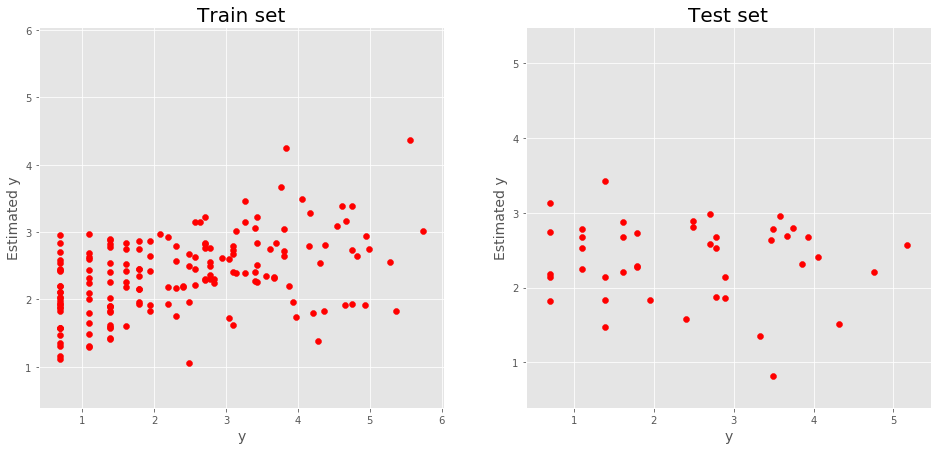

In [22]:
plot_yreal_ypred(y_test, y_train, X_test, X_train, model_regression)

## 4. Устойчивая к выбросам регрессия 

Последний этап нашей работы. Попробуем обучить на отобранных признаках устойчивую к выбросам регрессию. 

__[2]__ Оцените на устойчивую к выбросам линейную регрессию. Посмотрите на её MAE. Постройте для неё с помощью функции `plot_yreal_ypred`, которую я написал для вас выше, визуализацию её прогнозов. Сравните качество модели с константным прогнозом и с линейной регрессией. Сделайте выводы о работоспособности модели. 

In [24]:
from sklearn.linear_model import HuberRegressor

# Объявили модель
model_huber = HuberRegressor()

# Обучили модель на тренировочной выборке 
model_huber.fit(X_train, y_train)

# Сделали прогнозы на тестовой выборке 
y_pred_huber = model_huber.predict(X_test)

In [25]:
metrics.mean_absolute_error(y_test, y_pred_huber)

1.1927799078523835

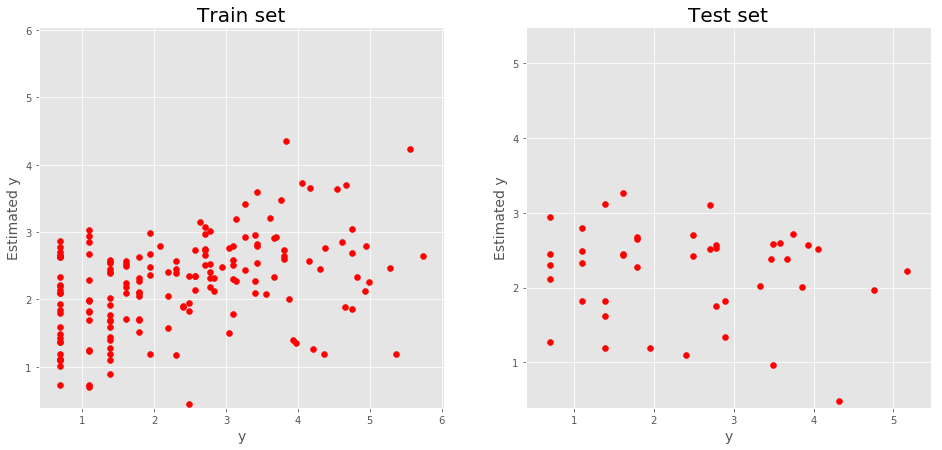

In [26]:
plot_yreal_ypred(y_test, y_train, X_test, X_train, model_huber)

__Ваши выводы:__ 

Бла бла бла... 